In [66]:
import numpy as np
import mrcfile as mrc
import matplotlib.pylab as plt

In [4]:
"p1 && p2 are 2 patches, laplace smoothing should smaller than 2 magnitute of mean of patches"
def patchSimilarity(p1, p2, laplace = 0.5):
    mu1 = np.mean(p1)
    mu2 = np.mean(p2)
    std1 = np.std(p1)
    std2 = np.std(p2)
    cov = np.mean(np.cov(p1,p2))
    SSIM = (2*mu1*mu2 + laplace)*(2*cov + laplace)/((mu1**2 + mu2**2 + laplace)*(std1**2 + std2**2 + laplace))
    return SSIM

In [2]:
class Crop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image, pos, stride = 2):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image

In [35]:
"assume input has one image with single channel"
def patch(image, out_size, stride = 2):
    h, w = image.shape[:2]
    out_h, out_w = out_size
    n_H = int(1 + (h - out_h) / stride)
    n_W = int(1 + (w - out_w) / stride) 
    
    crop_imgs = []
    for h in range(n_H):
        vert_start = h*stride 
        vert_end = h*stride + out_h
        for w in range(n_W):
            horiz_start = w*stride
            horiz_end = w*stride + out_w
            
            crop_pad = image[vert_start:vert_end,horiz_start:horiz_end]
            crop_imgs.append(crop_pad)
    return crop_imgs

In [11]:
def sub_patch(sub_img, sub_num, thre = 0.5):
    h, w = sub_img.shape[:2]
    seg_num = int(np.sqrt(sub_num))
    seg_h = h//seg_num
    seg_w = w//seg_num
    
    sub_patch = []
    for i in range(seg_num):
        for j in range(seg_num):
            sub_pad = sub_img[i*seg_h:(i+1)*seg_h,j*seg_w:(j+1)*seg_h]
            sub_patch.append(sub_pad)
    return sub_patch

In [59]:
def crop_patch(image, out_size, sub_num):
    patches = patch(image, out_size)
    noise_p = []
    for i in patches:
        sub_p = sub_patch(i, sub_num)
        
        score_list = [[] for i in range(len(sub_p))]
        for m in range(len(sub_p)):
            for n in range(m+1, len(sub_p)):
                score = patchSimilarity(sub_p[m], sub_p[n])
                score_list[m].append(score)
                score_list[n].append(score)
        score_list = np.array(score_list)
        for s in range(len(score_list)):
            if np.all(score_list[s]):
                noise_p.append(sub_p[s])
    return noise_p

In [70]:
mrc_data = mrc.open('HSP90_6830.mrcs',mode = 'r+')

In [73]:
mrc_mat = mrc_data.data

In [60]:
c = crop_patch(mrc_mat[0], (32,32), 4)

In [64]:
print(np.shape(c))

(9604, 16, 16)


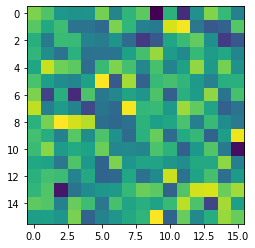

In [69]:
plt.imshow(c[19])